## Generating Networks with Log-Normal Degree Distribution

In [1]:
import random 
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

In [2]:
import sys
!{sys.executable} -m pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Generate coordinates for n nodes 
# n: Number of nodes 
# scale: Scaling factor for coordinates generated between [0, 1)
def generate_nodes(n, scale):
    return np.random.rand(n, 2) * scale

In [3]:
# Calculate the straight line distance between coordinates  
#     by applying Pythagoras' theorem (a^2 + b^2 = c^2)
# a: First coordinate pair 
# b: Second coordinate pair 
def pythag(a, b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

In [4]:
def depth_factor(i, j):
    return np.exp(-pythag(i, j))

In [5]:
def surface_factor(si, sj):
    return (si + sj)

In [6]:
def log_normal_adj(size, scale, degree):
    # Generate coordinates 
    nodes = generate_nodes(size, scale)
    
    # Define surface weights for each node
    surfaces = np.random.lognormal(mean = 0.0, sigma = 1.0, size = size)
    
    # Define surface factor between each and every pair of nodes 
    sf = [[surface_factor(i, j) for i in surfaces] for j in surfaces] 
          
    # Define depth factor between each and every pair of nodes 
    df = [[depth_factor(i, j) for i in nodes] for j in nodes]
    
    # Probability factors for each pair of nodes
    ep = np.multiply(df, sf)
    
    # For each pair of nodes
    # Assign edge with probability propotional to the depth factor 
    total_ep = np.sum(ep)
    
    # For each pair of nodes
    # Create an edge with probability proportional to dij 
    adj = np.zeros(shape = (size, size))

    # Roulette wheel 
    while degree > 0:
        prsum = 0.0 
        ptr = random.random() 
        
        for i, j in itertools.product(range(size), range(size)):  
            if i == j:
                continue 
            
            pr = ep[i][j] / total_ep
            prsum += pr 
            
            if prsum > ptr:
                degree = degree - 1
                adj[i, j] = ep[i][j]
                break
        
    return adj

In [7]:
def nx_log_normal(size, degree):
    # Generate coordinates in range [0, 1]
    scale = 1
    nodes = generate_nodes(size, scale)
    
    # Define surface weights for each node 
    surfaces = np.random.lognormal(mean = 0.0, sigma = 1.0, size = size)
    
    # Define the surface factor between every node pair 
    # Larger surfaces have greater probability to connect 
    sf = [[surface_factor(i, j) for i in surfaces] for j in surfaces] 
    
    # Define the depth factor between every pair of nodes 
    # Geometrically closer nodes have higher depth factor 
    df = [[depth_factor(i, j) for i in nodes] for j in nodes]
    
    # Calculate the existence probability for each edge 
    # depth_factor_ij * surface_factor_ij 
    ep = np.multiply(df, sf)
    total_ep = np.sum(ep)
    
    # Roulette wheel 
    # Create an edge (i, j) with Pr. proportional to ep_ij 
    edges_set = []
    
    while degree > 0:
        pr_sum = 0.0 
        ptr = random.random()
        
        for i, j in itertools.product(range(size), range(size)):
                if i == j:
                    continue 
                
                pr = ep[i][j] / total_ep
                pr_sum += pr 
                
                if pr_sum > ptr: 
                    edges_set.append((i, j, {'weight': pr}))
                    break
        
        degree = degree - 1 
    
    G = nx.Graph()
    G.add_nodes_from(range(size))
    G.add_edges_from(edges_set)
    
    return G 

In [29]:
sizes = [100, 225, 500]
graphs = []
for size in sizes:
    graphs.append(nx_log_normal(size, (size * 3)))

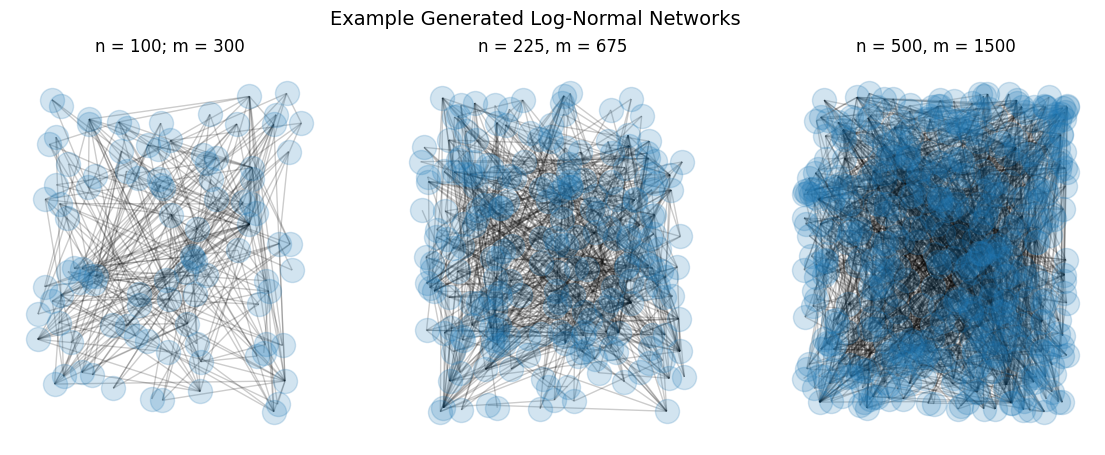

In [32]:
fig, axs = plt.subplots(1, 3, figsize = (14, 5))
fig.suptitle("Example Generated Log-Normal Networks", fontsize = 14)
for i in range(3):
    nx.draw_random(graphs[i], alpha = 0.2, ax = axs[i]) 
axs[0].set_title("n = 100; m = 300", fontsize = 12)
axs[1].set_title("n = 225, m = 675", fontsize = 12)
axs[2].set_title("n = 500, m = 1500", fontsize = 12)
plt.savefig("./plots/ln/example_sizes.jpg", dpi = 300)

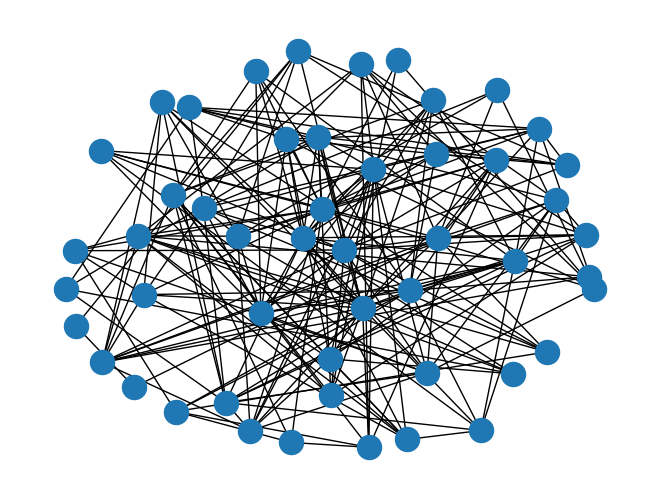

In [8]:
lng = nx_log_normal(50, 245)


nx.draw(lng)

Networks generated for this project should be connected such that a path does exist between any two pairs of nodes. This is achieved when there are no disconnected nodes. 

Because the log-normal generation algorithm is not gauranteed to produce connected graphs, the below function will continue to generate graphs of the desired size and density until a connected model is produced.

Methods such as adding connections or removing disconnected nodes may also be effective, but may change the degree distribution. 

In [9]:
def nx_connected_ln(size, degree):
    # Set a hard limit on the number of models generated
    # before exit
    max_iterations = 1000 
    
    # Generate models until connected
    for i in range(max_iterations):
        G = nx_log_normal(size, degree)
        
        # Check if G is connected 
        connected = True
        for node in range(size):
            if G.degree[node] == 0:
                connected = False
    
        if connected:
            return (connected, G)
    
    # Return the false flag and null model
    return (False, None)

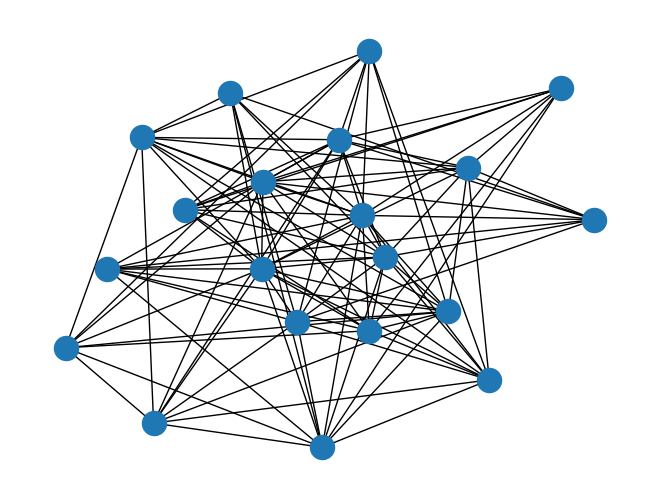

In [10]:
(flag, G) = nx_connected_ln(20, 200)

if flag:
    nx.draw(G)
else:
    print("Connected not found. Try greater degree.")

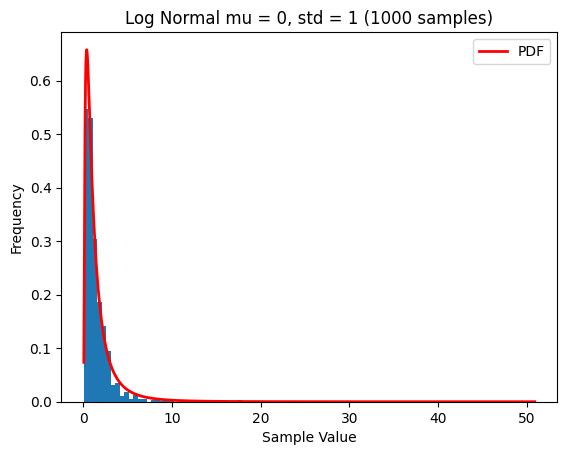

In [14]:
# Comprae the degree distribution of a generated graph with 
# standard log-normal distribution 

# Take 1000 samples from log normal distribution
mu, sigma, samples = 0, 1, 1000
ln = np.random.lognormal(mu, sigma, samples)

# Compute the histogram of samples
plt.figure()
count, bins, ign = plt.hist(ln, 100, density = True, align = 'mid')
x = np.linspace(min(bins), max(bins), (samples * 10))

# Calculate smooth probability density function
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.lognormal.html
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

# Plot historgram and pdf 
plt.plot(x, pdf, linewidth=2, color='r', label="PDF")
plt.legend()
plt.axis('tight')
plt.xlabel("Sample Value")
plt.ylabel("Frequency")
plt.title("Log Normal mu = 0, std = 1 (1000 samples)")
plt.savefig("./plots/ln/lognormal_dist.jpg", dpi = 300)
plt.show()

In [15]:
# Repeat for degree distribution 
# Generate a graph with 1000 nodes 
samples = 500
(flag, G) = nx_connected_ln(samples, (samples * 5))

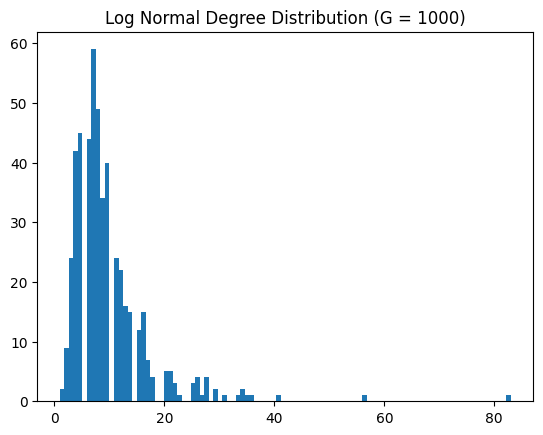

In [16]:
if flag:
    # Get degree sequence of graph 
    degree_seq = [d for (n, d) in G.degree]

    plt.figure()
    count, bins, ign = plt.hist(degree_seq, bins = 100, density = False, align = 'mid')
    plt.title("Log Normal Degree Distribution (G = 1000)")
    plt.show()

<Figure size 800x800 with 0 Axes>

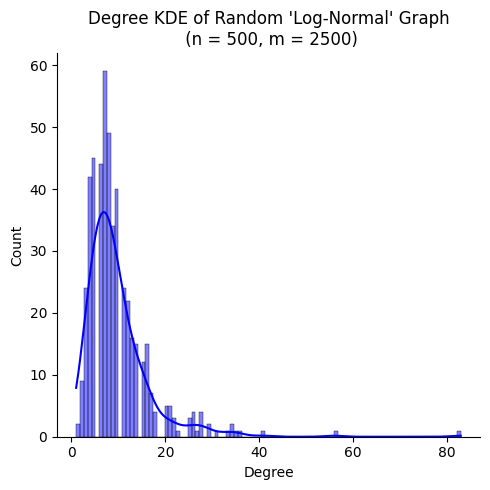

In [28]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.displot(degree_seq, kde=True, bins=100, color='blue')
plt.title("Degree KDE of Random 'Log-Normal' Graph\n (n = 500, m = 2500)")
plt.xlabel("Degree")
plt.tight_layout()
plt.savefig("./plots/ln/ln_degree_dist.jpg", dpi = 300)
plt.show()